# Исследовательский анализ данных

## 1. Предобработка данных

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Откроем таблицы с данными:

In [2]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_contract.name = 'contract'
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_internet.name = 'internet'
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_personal.name = 'personal'
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
df_phone.name = 'phone'
list_df = [df_contract, df_internet, df_personal, df_phone]

In [3]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [5]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Создадим функцию, делающую проверку на верный тип данных, проверку на пропуски, дубликаты

In [7]:
def analysis(data):
    
    print('Таблица ' + str(data.name) + '\n' + '---------------------------------')
    print(data.info(), '\n' + '---------------------------------')
    print('Количество пропусков: ' + '\n')
    print(data.isna().sum())
    print('---------------------------------' + '\n' + 'Количество дубликатов: ', df_contract.customerID.duplicated().sum())
    print('---------------------------------' + '\n') 

In [8]:
for value in list_df:
    analysis(value)

Таблица contract
---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None 
---------------------------------
Количество пропусков: 

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
---------------------------------
Количество дубликатов:  0
------

Из полученного результата следует, что во всех таблицах пропуски и дубликаты отсутствуют, неверный тип данных только в таблице `contract` у столбцов `BeginDate` и `EndDate` Однако в столбце `EndDate` может быть помимо даты и строка `No`. Поэтому сделаем замену на верный тип данных только в столбце `BeginDate`:

In [9]:
df_contract['BeginDate'] = pd.to_datetime(df_contract.BeginDate)
df_contract.TotalCharges = pd.to_numeric(df_contract.TotalCharges, errors = 'ignore')
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


## 2. Исследование данных

### 2.1 Исследование значений таблицы `contract`

Примем за целевой признак столбец `EndDate`, который показывает, ушел ли клиент. Для этого создадим столбец `end_contract`: 1 - контракт продолжается, 0 - контракт прекращен. А также проанализируем, какие факторы будут влиять на этот признак. Это будут следующие факторы:

1. `Type` - тип оплаты: вероятно, клиенты, производящие оплату на год / два сразу более надежные, чем оплачивающие помесячно; создадим столбец `type_payment`, где 0 - помесячная оплата, 1 - на год / два; 
2. `PaymentMethod` - способ оплаты: вероятно, клиенты, производящие оплату `Bank transfer (automatic)` (автоматическое списание средств с банковского счета) более уверены в своем выборе оператора и более надежны, чем остальные; создадим столбец `method_payment`, где 1 - автоматическое списание средств, 0 - другое;

Также для сравнение создадим столбец `contract_duration` с продолжительностью контракта: если контракт завершен, продолжительность будет равна разнице между `EndDate` и `BeginDate`, в противном случае - между `2020-02-01` и `BeginDate` (так как данные актуальны на 1 февраля 2020 года).

In [10]:
df_contract.loc[df_contract.EndDate == 'No', 'end_contract'] = 1
df_contract.loc[df_contract.EndDate != 'No', 'end_contract'] = 0

df_contract.loc[df_contract.Type != 'Month-to-month', 'type_payment'] = 1
df_contract.loc[df_contract.Type == 'Month-to-month', 'type_payment'] = 0

df_contract.loc[df_contract.PaymentMethod == 'Bank transfer (automatic)', 'method_payment'] = 1
df_contract.loc[df_contract.PaymentMethod != 'Bank transfer (automatic)', 'method_payment'] = 0

df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,end_contract,type_payment,method_payment
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,1.0,0.0,0.0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,1.0,1.0,0.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,0.0,0.0,0.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,1.0,1.0,1.0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,0.0,0.0,0.0


Определим, сколько процентов клиентов остались в Телекоме:

In [11]:
df_contract[df_contract.EndDate == 'No']['EndDate'].count() / df_contract.EndDate.count() * 100

73.4630129206304

То есть почти четверть клиентов ушла. 

Создадим столбец `contract_duration`:

In [12]:
# Создание дополнительной таблицы df_end_contract для клиентов, расторгнувших контракт
df_end_contract = df_contract.copy()
df_end_contract = df_contract[df_contract.EndDate != 'No']
df_end_contract.EndDate = pd.to_datetime(df_end_contract.EndDate)
df_end_contract['contract_duration'] = df_end_contract.EndDate - df_end_contract.BeginDate
df_end_contract = df_end_contract[['customerID', 'contract_duration']]

# Объединение таблиц df_end_contract и общей - df_contract
df_contract = df_contract.merge(df_end_contract, how = 'left', on = 'customerID')

# Заполнение пустых значение (клиентов, оставшихся в Телекоме) разницей BeginDate и 2020-02-01, приведение значений к дням
df_contract['contract_duration'] = df_contract['contract_duration'].fillna(pd.to_datetime('2020 - 02 - 01') 
                                                                                       - df_contract['BeginDate'])
df_contract['contract_duration'] = pd.to_numeric(df_contract['contract_duration']) / (1000000000 * 60 * 60 * 24)

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\USER\AppData\Local\Temp/ipykernel_213576/1962970311.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_end_contract['contract_duration'] = df_end_contract.EndDate - df_end_contract.BeginDate


In [13]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,end_contract,type_payment,method_payment,contract_duration
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,1.0,0.0,0.0,31.0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,1.0,1.0,0.0,1036.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,0.0,0.0,0.0,61.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,1.0,1.0,1.0,1371.0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,0.0,0.0,0.0,61.0


Проанализируем полученные данные:

Оценим, насколько зависит уход клиента от месячной стоимости услуг компании:

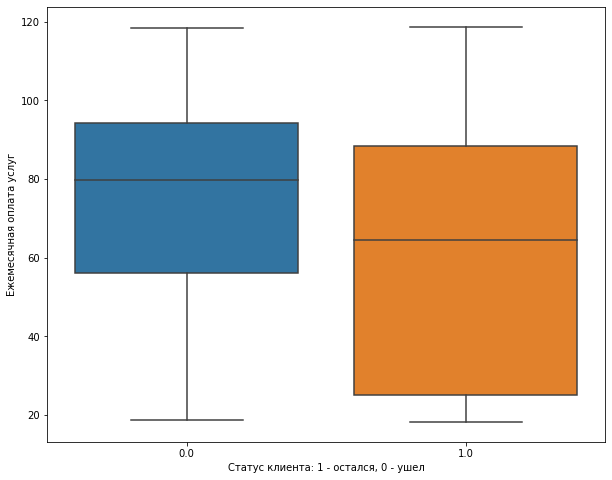

In [14]:
plt.figure(figsize = (10, 8))
sns.boxplot(data = df_contract, y = 'MonthlyCharges', x = 'end_contract').set(
                                        xlabel = 'Статус клиента: 1 - остался, 0 - ушел',
                                        ylabel = 'Ежемесячная оплата услуг');

Можно сделать вывод о том, что месячная стоимость услуг у ушедших клиентов значительно выше, чем у оставшихся

Оценим, насколько зависит уход клиента от продолжительности контракта:

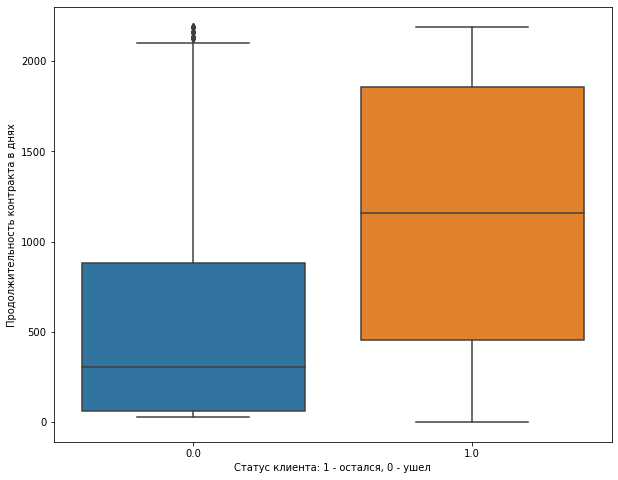

In [15]:
plt.figure(figsize = (10, 8))
sns.boxplot(data = df_contract, y = 'contract_duration', x = 'end_contract').set(
                                        xlabel = 'Статус клиента: 1 - остался, 0 - ушел',
                                        ylabel = 'Продолжительность контракта в днях');

Можно сделать вывод о том, что клиенты, пользующиеся услугами компании уже достаточно долго, более лояльны и надежны, чем те, которые пришли сравнительно недавно.

Проанализируем полученные результаты:

1. Ежемесячная стоимость влияет на уход клиента: стоимость услуг у ушедших клиентов значительно выше, чем у оставшихся;
2. Продолжительность контракта влияет на уход клиента: клиенты, пользующиеся услугами компании уже достаточно долго, более лояльны и надежны, чем те, которые пришли сравнительно недавно.

### 2.2 Исследование значений таблицы `personal`

Довольно значимой таблицей на уход клиента также может быть `personal`, которая содержит персональную информацию о клиентах. Объединим ее с таблицей `contract`, в которой останутся только ID номера клиентов и столбец `end_contract`:

In [16]:
df_personal_end_contract = df_contract.copy()
df_personal_end_contract = df_personal_end_contract[['customerID', 'end_contract']]
df_personal_end_contract = df_personal_end_contract.merge(df_personal, how = 'left', on = 'customerID')
df_personal_end_contract 

,customerID,end_contract,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,1.0,Female,0,Yes,No
1,5575-GNVDE,1.0,Male,0,No,No
2,3668-QPYBK,0.0,Male,0,No,No
3,7795-CFOCW,1.0,Male,0,No,No
4,9237-HQITU,0.0,Female,0,No,No
...,...,...,...,...,...,...
7038,6840-RESVB,1.0,Male,0,Yes,Yes
7039,2234-XADUH,1.0,Female,0,Yes,Yes
7040,4801-JZAZL,1.0,Female,0,Yes,Yes
7041,8361-LTMKD,0.0,Male,1,Yes,No


Выведем количество уникальных значений из таблицы `personal`:

In [17]:
list_df_personal_end_contract = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

for value in list_df_personal_end_contract:
    print('Уникальные значения столбца ' + value + ':')
    print(df_personal_end_contract[value].value_counts())
    print('\n')

Уникальные значения столбца gender:
Male      3555
Female    3488
Name: gender, dtype: int64


Уникальные значения столбца SeniorCitizen:
0    5901
1    1142
Name: SeniorCitizen, dtype: int64


Уникальные значения столбца Partner:
No     3641
Yes    3402
Name: Partner, dtype: int64


Уникальные значения столбца Dependents:
No     4933
Yes    2110
Name: Dependents, dtype: int64




Каждый столбец имеет по 2 значения: `Yes / No` или `1 / 0`.

Сделаем следующие предположения:

1. Пенсионеры менее мобильны в вопросе выбора оператора и неохотнее будут его менять при изменении условий в худшую для себя сторону;
2. Супруги предпочитают использовать одного оператора для экономии; создадим столбец `have_partner`, где 1 - у клиента есть супруг / супруга, 0 - нет;
3. Вероятно, клиенты, у которых есть люди на попечении, перекладывают вопрос оператора и за тех людей на себя, так как более экономно, как и в предположении с супругами; создадим столбец `have_dependents`: 1 - у клиента есть люди на попечении, 0 - нет. 

Касательно столбца `gender` сделать предположение сложно, кто более надежен для оператора - мужчины или женщины, поэтому просто создадим столбец `number_gender`, где 1 - мужчины, 0 - женщины.

In [18]:
df_personal_end_contract.loc[df_personal_end_contract.gender == 'Male', 'number_gender'] = 1
df_personal_end_contract.loc[df_personal_end_contract.gender != 'Male', 'number_gender'] = 0

df_personal_end_contract.loc[df_personal_end_contract.Partner == 'Yes', 'have_partner'] = 1
df_personal_end_contract.loc[df_personal_end_contract.Partner != 'Yes', 'have_partner'] = 0

df_personal_end_contract.loc[df_personal_end_contract.Partner == 'Yes', 'have_dependents'] = 1
df_personal_end_contract.loc[df_personal_end_contract.Partner != 'Yes', 'have_dependents'] = 0


In [19]:
df_personal_end_contract.head()

,customerID,end_contract,gender,SeniorCitizen,Partner,Dependents,number_gender,have_partner,have_dependents
0,7590-VHVEG,1.0,Female,0,Yes,No,0.0,1.0,1.0
1,5575-GNVDE,1.0,Male,0,No,No,1.0,0.0,0.0
2,3668-QPYBK,0.0,Male,0,No,No,1.0,0.0,0.0
3,7795-CFOCW,1.0,Male,0,No,No,1.0,0.0,0.0
4,9237-HQITU,0.0,Female,0,No,No,0.0,0.0,0.0


Построим матрицу корреляции:

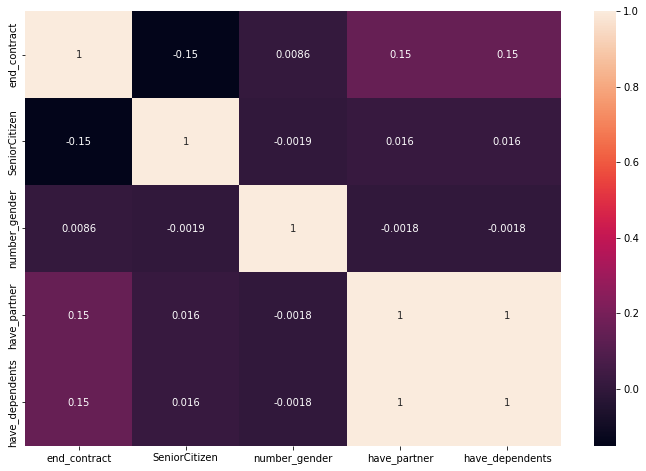

In [20]:
plt.figure(figsize = (12, 8))
sns.heatmap(df_personal_end_contract.corr(method = 'kendall'), annot = True);

Проанализируем полученные результаты:

1. На расторжение контракта оказывают очень слабое влияние столбцы `have_partner` и `have_dependents` (коэффициенты корреляции 0.15), то есть клиенты, у которых есть супруг / супруга или люди на попечении, являются более надежными, однако очень незначительно;
2. Связь между расторжением контракта и начилием у клиента пенсионного по возрасту есть, однако тоже очень слабая (коэффициент корреляции 0.15), то есть пенсионеры чаще уходят, чем молодые люди, но незначительно.
3. Остальные факторы на расторжение контрактов не влияют.

### 2.3 Выводы по исследовательскому анализу

Таким образом, на основе матриц корреляции таблиц, можно сделать выводы:

1. Ежемесячная стоимость влияет на уход клиента: стоимость услуг у ушедших клиентов значительно выше, чем у оставшихся;
2. Продолжительность контракта влияет на уход клиента: клиенты, пользующиеся услугами компании уже достаточно долго, более лояльны и надежны, чем те, которые пришли сравнительно недавно;
3. Прослеживается слабая корреляция между уходом клиента и типом оплаты (коэффициент ранговой корреляции Кендалла 0.41): клиенты, оплачивающие услуги сразу на год-два вперед чаще остаются;
4. Остальные факторы на расторжение контрактов не влияют.

То есть наиболее значимые факторы, влияющие на расторжение контракта - ежемесячная стоимость, продолжительность контракта, тип оплаты.

# План решения задачи

### Для получения модели заданного качества будем придерживаться следующего плана:

1. Объединение таблиц, анализ объединенной таблицы, разбиение признаков на целевой и остальные, кодирование столбцов строкового типа, добавление баланса классов, разбиение на обучающую и тестовую выборки.
2. Создание модели на первом алгоритме, подбор наилучших гиперпараметров, получение результата, проверка на кросс-валидации. Основная метрика - `AUC-ROC`, значение `random state` - 171022. При недостаточном качестве модели - изменение гиперпараметров модели.
3. Те же самые действия, как и в пункте 2, с моделью на другом алгоритме.
4. Сравнение полученных результатов моделей, анализ их качества, затраченного времени, формулировка выводов по данному пункту.

# Создание моделей

## 1. Подготовка признаков

Импортируем необходимые библиотеки:

In [21]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from lightgbm import LGBMClassifier

Откроем еще раз таблицы (прежние были видоизменены в исследовательском анализе):

In [22]:
df_contract_model = df_contract.copy()
df_contract_model = df_contract_model.drop(['end_contract', 'type_payment', 'method_payment'], axis = 1)
df_internet_model = pd.read_csv('/datasets/final_provider/internet.csv')
df_personal_model = pd.read_csv('/datasets/final_provider/personal.csv')
df_phone_model = pd.read_csv('/datasets/final_provider/phone.csv')

### 1.1 Объединение таблиц, проверка на пропуски объединенного датафрейма

Объединим все таблицы в один датафрейм:

In [23]:
df = df_contract_model.merge(df_personal_model, how = 'left', on = 'customerID')
df = df.merge(df_internet_model, how = 'left', on = 'customerID')
df = df.merge(df_phone_model, how = 'left', on = 'customerID')
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors = 'coerce').fillna(0)

Проанализируем, сколько пропусков появилось в результате объединения таблиц:

In [24]:
df.isna().sum()

customerID              0
BeginDate               0
EndDate                 0
Type                    0
PaperlessBilling        0
PaymentMethod           0
MonthlyCharges          0
TotalCharges            0
contract_duration       0
gender                  0
SeniorCitizen           0
Partner                 0
Dependents              0
InternetService      1526
OnlineSecurity       1526
OnlineBackup         1526
DeviceProtection     1526
TechSupport          1526
StreamingTV          1526
StreamingMovies      1526
MultipleLines         682
dtype: int64

Пропуски появились в столбцах таблиц `internet` и `phone`. Скорее всего, информации нет, так как клиенты не подключали перечисленные услуги. Заменим пропуски в этих столбцах на значение `No`:

In [25]:
df = df.fillna('No')

Проверим, все ли пропуски заполнились:

In [26]:
df.isna().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
contract_duration    0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
MultipleLines        0
dtype: int64

Пропуски заполнены, можем переходить к следующему пункту.

### 1.2 Анализ объединенного датафрейма

Произведем анализ данных объединенного датафрейма. Анализ данных таблиц `contract` и `personal` Уже был произведен (в том числе и с объединением таблиц, т.к. количество строк одинаковое, пункт 2.2, исследовательский анализ). Обратим внимание именно на столбцы из таблиц `internet` и `phone`:

InternetService


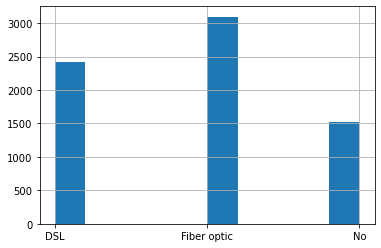

OnlineSecurity


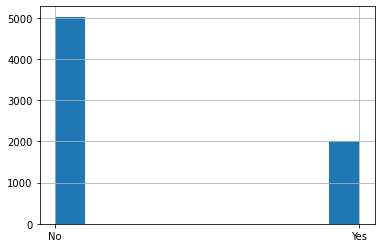

OnlineBackup


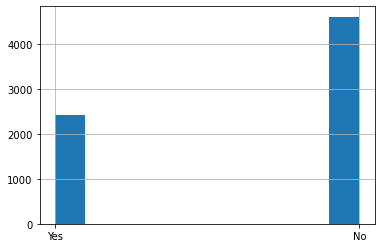

DeviceProtection


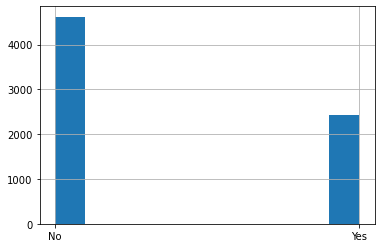

TechSupport


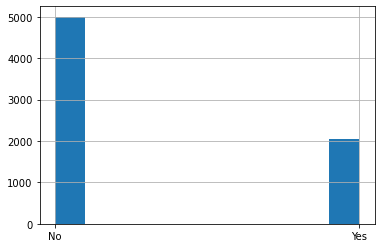

StreamingTV


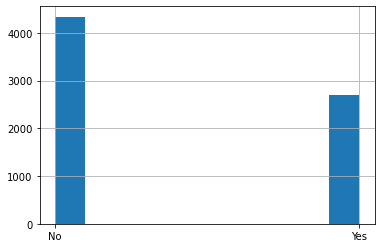

StreamingMovies


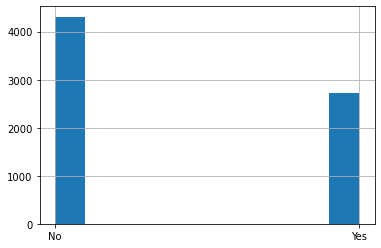

MultipleLines


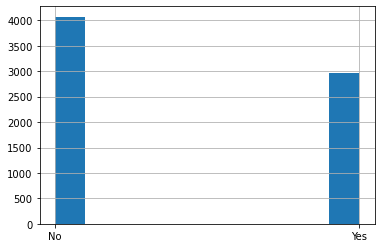

In [27]:
df_internet_phone = df[['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                        'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']]

for value in df_internet_phone.columns.to_list():
    df_internet_phone[value].hist(grid = True)
    print(value)
    plt.show()

Из полученных диаграмм можно сделать выводы о том, что значений `Yes` гораздо меньше, чем `No`, при этом в большинстве случаев количество клиентов с подключенными услугами - 1/4, 1/3 от общего количества.

Проанализируем, какая корреляция между столбцом `TotalCharges` и ежемесячной оплатой, а также длительностью контракта. Так как оплата помесячная, переведем значения столбеца `contract_duration` в количество месяцев из кол-ва дней. После этого создадим столбец `Total_check`, который будет равен произведению `MonthlyCharges` на `contract_duration` и проверим корреляцию:

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\USER\AppData\Local\Temp/ipykernel_213576/468999109.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TotalCharges['Total'] = df_TotalCharges.MonthlyCharges * df_TotalCharges.contract_duration


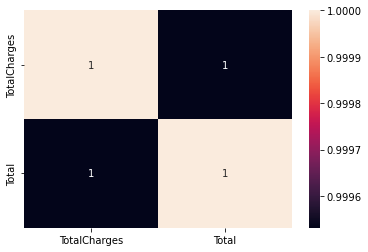

In [28]:
df_TotalCharges = df[['TotalCharges', 'MonthlyCharges', 'contract_duration']]
df_TotalCharges.contract_duration = round(df_TotalCharges.contract_duration / 31)

df_TotalCharges['Total'] = df_TotalCharges.MonthlyCharges * df_TotalCharges.contract_duration
df_TotalCharges = df_TotalCharges.drop(['MonthlyCharges', 'contract_duration'], axis = 1)

sns.heatmap(df_TotalCharges.corr(), annot = True);

Корреляция между общей суммой и произведением ежемесячной оплаты на количество месяцев контракта - 1

Проанализируем, какие столбцы информативны для обучения моделей, а какие избыточны или лишние.

1. Столбец `customerID` - явно лишний, так как это индивидуальный номер клиента, не влияющий на его решение уйти; столбец можно удалить;
2. Столбец `TotalCharges` - избыточный, так как его можно восстановить по продолжительности контракта и ежемесячной оплате; необходимо удалить, иначе он может привести к переобучению моделей;
3. Столбец `EndDate` - фактически целевой признак; его необходимо видоизменить: строки `No` - на 1 (клиент остался), остальные - 0 (клиент ушел); также из-за изменения `EndDate` необходимо добавить столбец, в котором будет содержаться информация о продолжительности контракта: если клиент ушел, продолжительность - разница между `EndDate` и `BeginDate`, если остался - между `2020-02-01` и `BeginDate` (данные актуальны на 1 февраля 2020 года); этот столбец можем взять из исследовательского анализа, `contract_duration`;
4. После добавления столбца `contract_duration` `BeginDate` также является избыточным (мы перешли от дат к продолжительности контрактов клиентов), его необходимо удалить;
4. Столбцы с категориальными данными необходимо закодировать.

Удалим столбцы `customerID` и `TotalCharges`:

In [29]:
df = df.drop(['customerID', 'TotalCharges'], axis = 1)

Изменим столбец `EndDate`:

In [30]:
df.loc[df.EndDate == 'No', 'end_contract'] = 1
df.loc[df.EndDate != 'No', 'end_contract'] = 0
df = df.drop(['EndDate', 'BeginDate'], axis = 1)

### 1.3 Разбиение признаков, кодировка, баланс классов

Определим значение `random_state`:

In [31]:
random_state = 171022

Разделим датасет на целевой признак - `target` и остальные - `features`:

In [32]:
target = df.end_contract
features = df.drop(['end_contract'], axis = 1)

Разделим на обучающую выборку - `train` и тестовую - `test` в отношении `3 : 1` :

In [33]:
features_train, features_test, target_train, target_test = train_test_split(
                                features, target, test_size = 0.25, random_state = random_state, stratify = target)

Для всех численных признаков примем одинаковый масштаб:

In [34]:
scaler = StandardScaler()
numeric_columns = ['MonthlyCharges', 'contract_duration']

scaler.fit(features_train[numeric_columns])
pd.options.mode.chained_assignment = None

features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

Закодируем все категориальные признаки техникой OrdinalEncoder:

In [35]:
features_train = features_train.reset_index(drop = True)
features_test = features_test.reset_index(drop = True)
target_train = target_train.reset_index(drop = True)
target_test = target_test.reset_index(drop = True)

categorial_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 
                       'gender', 'SeniorCitizen', 'Partner', 'Dependents',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

encoder = OrdinalEncoder()
features_train[categorial_columns] = pd.DataFrame(encoder.fit_transform(features_train[categorial_columns]), 
                                                  columns = categorial_columns)
features_test[categorial_columns] = pd.DataFrame(encoder.transform(features_test[categorial_columns]), 
                                                  columns = categorial_columns)

Проанализируем дисбаланс классов:

In [36]:
df_ones = target[target == 1]
df_zeros = target[target == 0]
print(df_ones.shape)
print(df_zeros.shape)
print(df_ones.shape[0] / df_zeros.shape[0])

(5174,)
(1869,)
2.7683253076511503


Отношение единиц к нулям в целевом признаке примерно 2.77. Однако основной метрикой при обучении модели является `auc_roc`, влияние дисбаланса на которую не оказывает большого влияния. Поэтому можем не учитывать дисбаланс при подготовке признаков.

## 2. Обучение моделей и тестирование лучшей

### 2.1 Модель RF

Создадим первую модель на алгоритме Random Forest. Введем перебор гиперпараметров:

In [37]:
set_numbers_RF = []
[set_numbers_RF.append(index) for index in range(1, 25)]

parameters_RF = {  
    'max_depth' : set_numbers_RF,
    'n_estimators' : set_numbers_RF
}

Определим наиболее подходящие гиперпараметры модели, а также произведем кросс-валидацию на них

In [38]:
%%time

model_RF = RandomForestClassifier(random_state = random_state)
model_RF_param = GridSearchCV(estimator = model_RF, param_grid = parameters_RF, cv = 5, 
                                    scoring = 'roc_auc')
model_RF_param.fit(features_train, target_train)
    
print('Значения гиперпараметров: ', model_RF_param.best_params_)

scores_model_RF = cross_val_score(model_RF_param, features_train, target_train, scoring = 'roc_auc', cv = 3)
scores_model_RF_result = scores_model_RF.sum() / len(scores_model_RF)
print('AUC-ROC: ', scores_model_RF_result)

Значения гиперпараметров:  {'max_depth': 6, 'n_estimators': 23}
AUC-ROC:  0.8549580259020484
Wall time: 9min 30s


### 2.2 Модель LightGBM

Создадим модель на алгоритме LightGBM. Введем перебор гиперпараметров:

In [39]:
set_numbers_LGBM = []
[set_numbers_LGBM.append(index) for index in range(1, 25)]

parameters_LGBM = {  
    'max_depth' : set_numbers_LGBM,
    'n_estimators' : set_numbers_LGBM
}

Определим наиболее подходящие гиперпараметры модели, а также произведем кросс-валидацию на них

In [40]:
%%time

model_LGBM = LGBMClassifier()
model_LGBM_param = GridSearchCV(estimator = model_LGBM, param_grid = parameters_LGBM, cv = 5, 
                                    scoring = 'roc_auc')
model_LGBM_param.fit(features_train, target_train)
    
print('Значения гиперпараметров: ', model_LGBM_param.best_params_)

scores_model_LGBM = cross_val_score(model_LGBM_param, features_train, target_train, scoring = 'roc_auc', cv = 3)
scores_model_LGBM_result = scores_model_LGBM.sum() / len(scores_model_LGBM)
print('AUC-ROC: ', scores_model_LGBM_result)

Значения гиперпараметров:  {'max_depth': 16, 'n_estimators': 24}
AUC-ROC:  0.8654688429844093
Wall time: 3min 22s


### 2.3 Тестирование лучшей модели

По результатам кросс-валидации лучшей моделью является `LightGBM`. Проверим ее качество на тестовых данных:

In [41]:
auc_roc_test = metrics.roc_auc_score(target_test, model_LGBM_param.predict_proba(features_test)[:, 1])
print('AUC-ROC: ', auc_roc_test)

AUC-ROC:  0.8705630334702414


## 3. Выводы

Таким образом, можно сделать следующие выводы:

1. И модель RF, и модель LightGBM производят довольно точное предсказание, проверка на кросс-валидации: RF - 0.8549, LightGMB - 0.8655;
2. Модель RF обучается примерно в 3 раза дольше, чем LightGBM: RF - 9min 30s, LightGBM - 3min 22s;
3. Качество лучшей модели на лучшей модели - LightGBM - оказалось выше, чем на кросс-валидации, и составляет 0.8706.

# Итоговый отчет

В ходе выполнения работы были проведены исследовательский анализ данных, объединение таблиц в один датафрейм и на его основе создана и обучена модель, определяющая, остается ли клиент или уходит.

Исходя из намеченного плана и фактической работой по созданию модели, можем сделать выводы, что все пункты плана выполнены, а именно:

1. Преобработка данных
2. Исследовательский анализ данных
3. Объединение таблиц, проверка на пропуски объединенного датафрейма
4. Анализ объединенного датафрейма
5. Разбиение признаков, кодировка, баланс классов
6. Обучение моделей и тестирование лучшей

Основной трудностью для создания модели, на мой взгляд, был именно анализ данных после объедидения таблиц: на первый взгляд сложно оценить, какие столбцы ключевые в создании модели, какие менее важные, какие даже стоит убрать или заменить из-за высокой вероятности переобучения. Основным методом при решении данной задачи была проверка корреляции между соответствующими столбцами, а также оценка по графиками распределения данных.

В процессе решения ключевыми, на мой взгляд, были следующие шаги:
1. Анализ данных объединенного датафрейма, так как очень важно проанализировать столбцы перед обучением модели;
2. Поиск наилучших гиперпараметров и кросс-валидация для обучения модели;
3. Тестирование лучшей из полученных моделей на тестовой выборке, так как мы получаем представление, как будет вести себя модель на незивестных ранее ей данных.

Все они были успешно преодолены в ходе решения задачи.

Итоговой моделью была принята модель LightGBM с качеством на кросс-валидации - 0.8655, а на тестовой выборке - 0.8706, при этом затраченное время на обучение модели состовило 3 минуты 22 секунды.